# How to use MutexWatershed

#### Since this tutorial takes place in a colab notebook we will have to install conda first. If you follow this locally you should instead install conda/miniconda (see https://docs.conda.io/en/latest/miniconda.html)

In [1]:
import sys
import affogato

Also we will download some precomputed affinities:

In [2]:
# !rm download*
# !wget https://hcicloud.iwr.uni-heidelberg.de/index.php/s/K6HBFi7Nr5rCuIA/download
# !mv download affogato/example/isbi_test_affinities.h5

## Running MutexWatershed on your data



### Loading affinities


(512, 512)


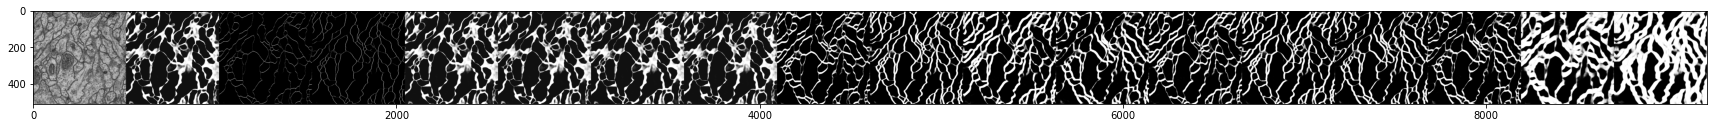

In [4]:
import h5py
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

os.chdir('/home/rcardiff/ryan/ryan')
with h5py.File('affogato/example/isbi_test_affinities.h5', "r") as infile:
  raw = infile["raw"][:]
  affinities = infile["affinities"][:]

print(raw[4].shape)
fig = plt.figure(figsize=(30,10))
plt.imshow(np.concatenate((raw[4], ) + tuple(affinities[c, 4] for c in range(len(affinities))), axis=1), cmap='gray')



In [17]:
f = h5py.File('affogato/example/isbi_test_affinities.h5', "r")
list(f.keys())
print(f['affinities'].shape)
print(f['raw'].shape)

print(affinities[16][4])

(17, 5, 512, 512)
(5, 512, 512)
(5, 512, 512)


In [71]:
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 14))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

(512, 512)


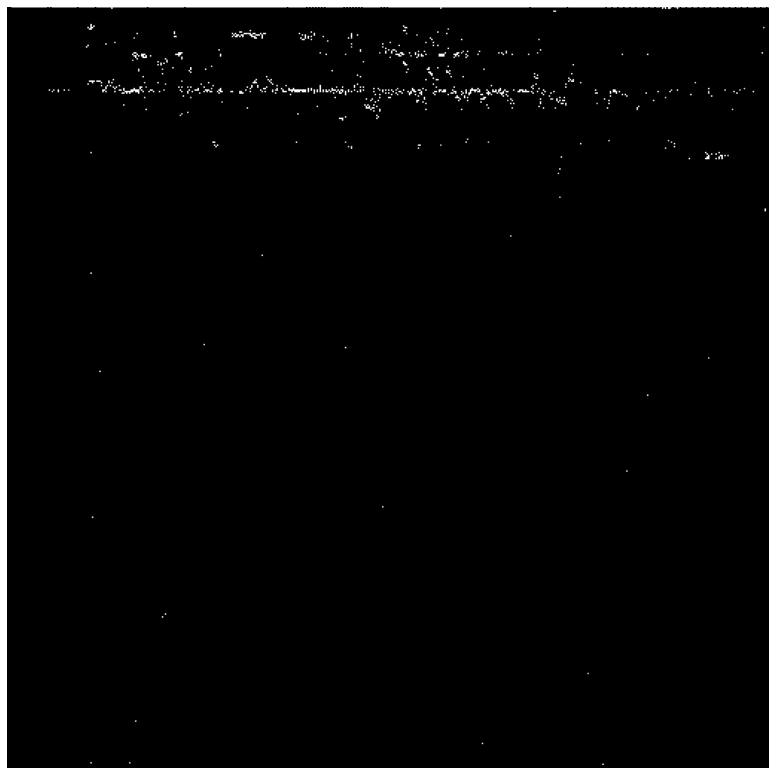

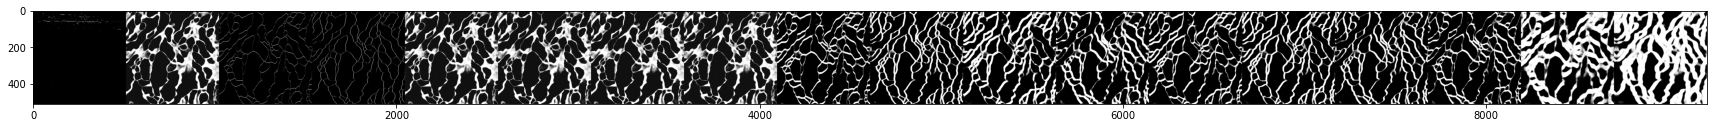

In [73]:
import cv2
from skimage.color import rgb2gray
import os
#len(raw[4][0])
#len(affinities)
#f = h5py.File("affogato/example/isbi_test_affinities.h5", "r")
#list(f.keys())

os.chdir('/home/rcardiff/ryan/ryan')
img = cv2.imread('high_res_test/neg_CL1.png')
img_crop = img[0:512,0:512]
img_crop = rgb2gray(img_crop)
image_show(img_crop)
print(img_crop.shape)
fig = plt.figure(figsize=(30,10))
plt.imshow(np.concatenate((img_crop, ) + tuple(affinities[c, 4] for c in range(len(affinities))), axis=1), cmap='gray')


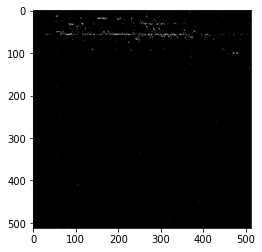

In [74]:
plt.imshow(img_crop, cmap = 'gray')

Theses affinities correspond to the following offsets

In [75]:
offsets = [[-1, 0, 0], [0, -1, 0], [0, 0, -1],
           # direct 3d nhood for attractive edges
           [-1, -1, -1], [-1, 1, 1], [-1, -1, 1], [-1, 1, -1],
           # indirect 3d nhood for dam edges
           [0, -9, 0], [0, 0, -9],
           # long range direct hood
           [0, -9, -9], [0, 9, -9], [0, -9, -4], [0, -4, -9], [0, 4, -9], [0, 9, -4],
           # inplane diagonal dam edges
           [0, -27, 0], [0, 0, -27]]

### Repulsive graph weights

Emprically, we have found that a combination of short-range attractive and long-range repulsive edges yields the best performance on our datasets.
Therefore we will transform the affinities to repulsive and attractive weights

In [8]:
# attractive_repuslive_weights.shape

In [9]:
# import mutex_watershed

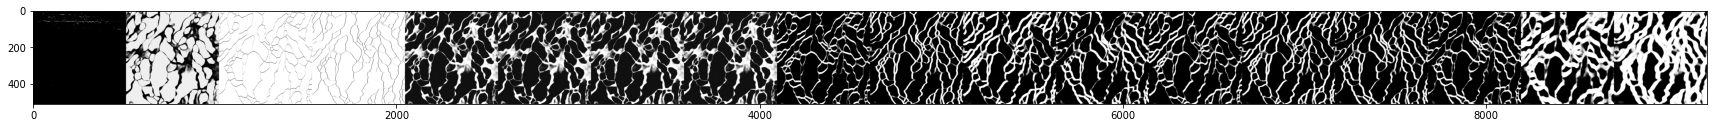

In [76]:
attractive_repuslive_weights = affinities.copy()

seperating_channel = 3
attractive_repuslive_weights[:seperating_channel] *= -1
attractive_repuslive_weights[:seperating_channel] += +1

fig = plt.figure(figsize=(30,10))
plt.imshow(np.concatenate((img_crop, ) + tuple(attractive_repuslive_weights[c, 4] for c in range(len(attractive_repuslive_weights))), axis=1), cmap='gray')

## Run Mutex Watershed

Now let's run the MWS. Note that we can influence the runtime of the algorithm by using only a subset of repulsive edges. To this end we set strides=[1, 10, 10].

In [77]:
from affogato.segmentation import compute_mws_segmentation

seg = compute_mws_segmentation(attractive_repuslive_weights, offsets, seperating_channel, strides=[1, 10, 10])

That's it!

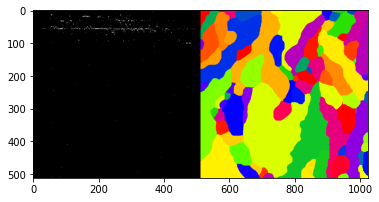

In [79]:
from matplotlib import cm
show_raw = cm.gray(img_crop)
show_seg = cm.prism(seg[4] / seg[4].max())
plt.imshow(np.concatenate((show_raw, show_seg, ), axis=1)) 